# Community Detection

Community Detection is an unsupervised task, where no label information can be used to train a graph neural network. Its ultimate objective is to group (cluster) nodes into groups. A natural way to do community detection is to learn node embeddings in an unsupervised manner and then perform clustering algorithms on the node embeddings.

<hr/>

### Node Embedding Algorithms
##### Doesn't require node features
- Adjacency matrix
- Node2Vec
- Watch your step

##### Requires node features
- Deep Graph Infomax (DGI) - extracts self information of graph as well as each node representation and then maximize the mutual information between graph representation and node representations.
- Attr2vec - learns node representations by performing a linear/non-linear mapping on node content attributes.
- Unsupervised GraphSAGE - given a large set of "positive" node pairs generated from random walks performed on the graph, and an equally large set of "negative" node pairs that are randomly selected from the graph according to a certain distrubution, learn a binary classifier that predicts whether arbitrary node pairs are likely to co-occur in a random walk. Through learning this simple binary node-pair-classification task, the model automatically learns an inductive mapping from attirubtes of nodes and their neighbors to node embeddings in a high-dimensional vector space.

### Clustering Algorithms
##### Common ML clustering algorithms to use from sklearn
- K-means
- Hierarchical clustering, a.k.a. Agglomerative Clustering
- DBSCAN
- Gaussian Mixture

### Combined Algorithms
- Fast Greedy
- Infomap
- Label Propagation
- Leading eigenvector
- Leiden
- Multilevel (Louvain)
- Walktrap

### Future algorithm consideration
- CommDGI
- Optimal Modularity

### Algorithms out of scope and its reason
- Edge betweenness - too slow
- Leading eigenvector_naive - doesn't support?
- Optimal Modularity - igraph error
- Spinglass - doesn't work with disconnected graphs
- GraphWave - Not practical

##### Resources:
- Clustering Algorithms in sklearn: https://scikit-learn.org/stable/modules/clustering.html

In [1]:
# General package needs
import random
import pandas as pd
import numpy as np
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore') # supress warnings due to some future deprications

# Graph-related package
import networkx as nx
import igraph as ig

from networkx.linalg.graphmatrix import adjacency_matrix

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
# ML/AI specific
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn import metrics
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from stellargraph.mapper import (
    CorruptedGenerator,
    FullBatchNodeGenerator,
    GraphSAGENodeGenerator,
    HinSAGENodeGenerator,
    ClusterNodeGenerator,
)
from stellargraph import StellarGraph
from stellargraph.layer import GCN, DeepGraphInfomax, GraphSAGE, GAT, APPNP, HinSAGE
from stellargraph.utils import plot_history

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from IPython.display import display, HTML

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import Model

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras

from stellargraph import globalvar
random.seed(123)


# Read Dataset

In [3]:
# Temporary read from opensea
node_df = pd.read_csv("../data/opensea_nodes_oct16.csv")
edge_df = pd.read_csv("../data/opensea_edges_oct16.csv")
node_df = node_df.append(pd.DataFrame(['nan'], columns = ['Id']))

In [4]:
edge_df = edge_df.dropna(subset=['SellerAddress', 'WinnerAddress']).reset_index()

In [5]:
edge_df.head()

index                               SellerAddress  \
0     18  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1     23  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7   
2     33   0xa4eafeb533d4111a1fe3a8b323c468976ac2323   
3     38  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4     43  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a   

                                WinnerAddress            Timestamp  \
0  0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7  2021-04-11T20:10:12   
1  0x0a4eafeb533d4111a1fe3a8b323c468976ac2323  2021-04-11T01:20:32   
2    0xd7c902fbbcd3c9db2da80a439c94486c50eb81  2017-07-10T14:03:38   
3  0xe369a8d4e8799d381cd5734eafd812cfb5c2574a  2021-02-15T08:50:46   
4  0xd93033ac253ce4320128666d999c392cfc09a523  2021-02-15T08:15:30   

    EventType PaymenTokenSymbol            TotalPrice  TokenId  \
0  successful               ETH  79990000000000000000     9159   
1  successful               ETH  56500000000000000000     9159   
2  successful               ETH                     0     9159   
3  successful               ETH  10000000000000000000     9158   
4  successful               ETH   8000000000000000000     9158   

                         AssetContractAddress  AssetId  TransactionId  \
0  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345    100167026.0   
1  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345     99767950.0   
2  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178345       368886.0   
3  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81978766.0   
4  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530610     81973239.0   

  BidAmount  AssetNumSales                           AssetOwnerAddress  \
0       NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
1       NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
2       NaN              3  0x906e55e1035c8a0828f249c173d8090e8fd5f189   
3       NaN              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   
4       NaN              2  0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d   

  FromAccountAddress  UsedEthscan  \
0                NaN        False   
1                NaN        False   
2                NaN         True   
3                NaN        False   
4                NaN         True   

                                     TransactionHash  
0  0xe4c985d1dadf4be3b1bca5dc4a4d44806c676c850cc0...  
1  0x18fb2f51fc2d939e2936e86657ee4eeb6d73792b865c...  
2  0x9c335e2621879e05a6c7e7948af58a671d9efae7e439...  
3  0x2b67c566d72d2cd4091960a89eed1c2a9825f985aa53...  
4  0x13c69a9e2178f2a3c445f3a382b8e103135a6d707021...

In [6]:
node_ID_col = ['Id']
node_label_col = []
node_feature_cols = []

edge_ID_col = ['index']
edge_src_col = 'SellerAddress'
edge_dst_col = 'WinnerAddress'
edge_feature_cols = ['TotalPrice']

# Step 1. Define Graph in Networkx Format

In [7]:
G = nx.Graph()
G.add_nodes_from(node_df[node_ID_col].values.flatten().tolist())
G.add_edges_from(edge_df[[edge_src_col, edge_dst_col]].values)

In [8]:
# Add node features
nx.set_node_attributes(G, node_df.set_index(node_ID_col)[node_feature_cols].to_dict())
# Add edge features
nx.set_edge_attributes(G, edge_df.set_index([edge_src_col, edge_dst_col])[edge_feature_cols].transpose().to_dict())
# TODO: If weights exist, add. This is out of scope for MVP

In [9]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 5124
Number of edges: 12226
Average degree:   4.7721


In [10]:
from stellargraph import datasets
dataset = datasets.Cora()
display(HTML(dataset.description))
stellarG, node_subjects = dataset.load()

In [11]:
stellarG = StellarGraph.from_networkx(G)

In [12]:
del node_df
del edge_df

In [13]:
# translate the object into igraph
g_ig = ig.Graph.Adjacency(
    (nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED
)
g_ig.summary()

'IGRAPH U--- 5124 12226 -- '

### Querying graph structures

In [45]:
print("# Nodes", G.number_of_nodes())
print("# Edges", G.number_of_edges())
# print("Node 0 has {} degree".format(G.degree(0)))
# print("Neighbors from Node 0:", G.neighbors(0))
print("Is this multigraph?", G.is_multigraph())
# print("Does this graph has node 329?", G.node(329))
print("Is there an edge between 329 and 324?", G.has_edge(329, 324))

# Nodes 5124
# Edges 12226
Is this multigraph? False
Is there an edge between 329 and 324? False


In [46]:
print("The graph is disconnected into {} networks".format(nx.number_connected_components(G)))

Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes)

The graph is disconnected into 292 networks
[4736, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


The distribution of connected components' sizes shows that there is a single large component, and a few isolated groups.

We expect the community detection/node embedding clustering algorithms to discover non-trivial communities that are not simply the connected components of the graph.

# Visualizing graph
This part is skipped (or not useful) as it will be done outside of this notebook in order to be more interactive.

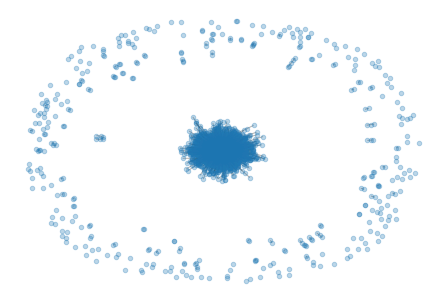

In [111]:
nx.draw(G, node_size=20, alpha=0.3)

In [112]:
ig.plot(g_ig)

# AI Experiment

In [113]:
model_options = [['AdjMatrix', 'KMeans'], 
                 ['AdjMatrix', 'HierarchicalClustering'], 
                 ['AdjMatrix', 'DBSCAN'],
                 ['AdjMatrix', 'GaussianMixture']
                ]
model_options = [['FastGreedy'], 
                 ['Infomap'], 
                 ['LabelPropagation'], 
                 ['LeadingEigenvector'], 
                 ['Leiden'], 
                 ['Multilevel'], 
                 ['OptimalModularity'], 
                 ['Walktrap']]

n_clusters = range(4, 9)
dist_thr = range(3, 10, 2)

eps=[0.3, 0.2]
min_samples = [3, 5]

In [ ]:
output = node_df.set_index('Id')

Clustering with 5124 elements and 824 clusters


<BarContainer object of 824 artists>

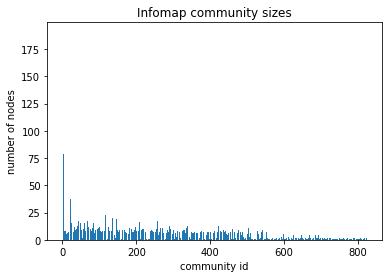

In [153]:
c_infomap = g_ig.community_infomap()
print(c_infomap.summary())
output.loc[list(G.nodes), 'cluster_infomap'] = c_infomap.membership

# plot the community sizes
infomap_sizes = c_infomap.sizes()
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)


Dendrogram, 5124 elements, 4832 merges


<BarContainer object of 342 artists>

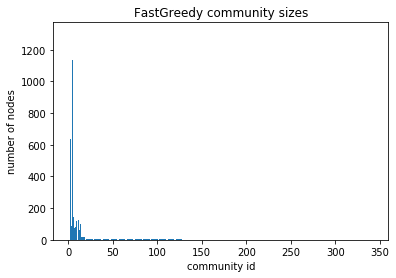

In [160]:
c_fastgreedy = g_ig.community_fastgreedy()
print(c_fastgreedy.summary())
c_fastgreedy_membership = ig.community_to_membership(c_fastgreedy.merges, len(node_df), len(c_fastgreedy.merges) - 50)
output.loc[list(G.nodes), 'cluster_fast_greedy'] = c_fastgreedy_membership

# plot the community sizes
cluster_sizes = output['cluster_fast_greedy'].value_counts().sort_index().values.tolist()
plt.title("FastGreedy community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)


Clustering with 5124 elements and 310 clusters


<BarContainer object of 310 artists>

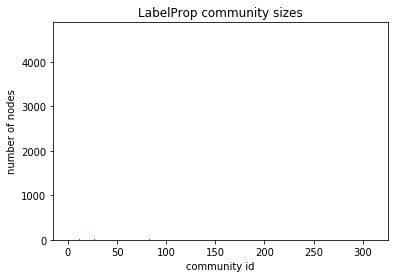

In [164]:
c_label = g_ig.community_label_propagation()
print(c_label.summary())
output.loc[list(G.nodes), 'cluster_label_prop'] = c_label.membership

# plot the community sizes
cluster_sizes = c_label.sizes()
plt.title("LabelProp community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)


Clustering with 5124 elements and 314 clusters


<BarContainer object of 314 artists>

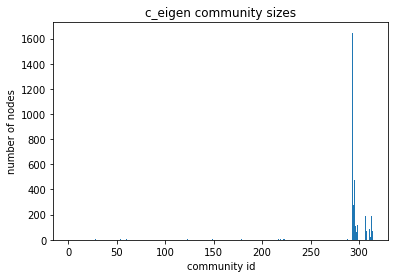

In [166]:
c_eigen = g_ig.community_leading_eigenvector()
print(c_eigen.summary())
output.loc[list(G.nodes), 'cluster_eigenvec'] = c_eigen.membership

# plot the community sizes
cluster_sizes = c_eigen.sizes()
plt.title("c_eigen community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)


Clustering with 5124 elements and 5124 clusters


<BarContainer object of 5124 artists>

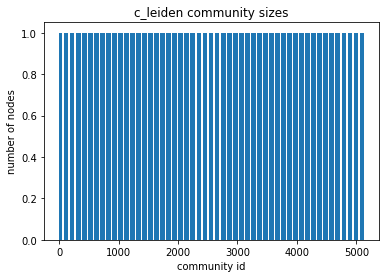

In [167]:
c_leiden = g_ig.community_leiden() # Note that there are hyperparameters that can be propvided
print(c_leiden.summary())
output.loc[list(G.nodes), 'cluster_leiden'] = c_leiden.membership

# plot the community sizes
cluster_sizes = c_leiden.sizes()
plt.title("c_leiden community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)


Clustering with 5124 elements and 311 clusters


<BarContainer object of 311 artists>

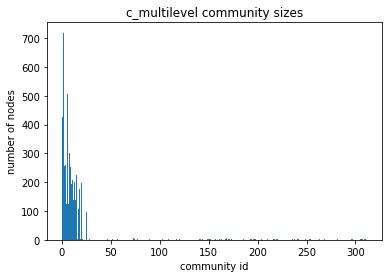

In [168]:
c_multilevel = g_ig.community_multilevel()
print(c_multilevel.summary())
output.loc[list(G.nodes), 'cluster_multilevel'] = c_multilevel.membership

# plot the community sizes
cluster_sizes = c_multilevel.sizes()
plt.title("c_multilevel community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)

Dendrogram, 5124 elements, 4832 merges


<BarContainer object of 342 artists>

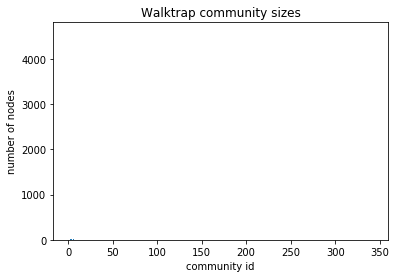

In [161]:
c_walktrap = g_ig.community_walktrap()
print(c_walktrap.summary())
c_walktrap_membership = ig.community_to_membership(c_walktrap.merges, len(node_df), len(c_walktrap.merges) - 50)
output.loc[list(G.nodes), 'cluster_walktrap'] = c_walktrap_membership

# plot the community sizes
cluster_sizes = output['cluster_walktrap'].value_counts().sort_index().values.tolist()
plt.title("Walktrap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(cluster_sizes) + 1)), cluster_sizes)


In [169]:
for i, subgraph in enumerate(Gcc):
    output.loc[list(subgraph.nodes), 'subgraph_id'] = i

In [170]:
output.to_csv("temp_output.csv")

In [23]:
from stellargraph.core import StellarGraph
from stellargraph.mapper import AdjacencyPowerGenerator
from stellargraph.layer import WatchYourStep
from stellargraph.losses import graph_log_likelihood
from stellargraph import datasets
from stellargraph.utils import plot_history

from matplotlib import pyplot as plt
from tensorflow.keras import optimizers, Model, layers, regularizers
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML

import networkx as nx
import random
import numpy as np
import pandas as pd
import os

In [24]:
tf.random.set_seed(1234)

In [26]:
generator = AdjacencyPowerGenerator(stellarG, num_powers=10)

In [27]:
wys = WatchYourStep(
    generator,
    num_walks=80,
    embedding_dimension=128,
    attention_regularizer=regularizers.l2(0.5),
)
x_in, x_out = wys.in_out_tensors()

In [28]:
model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=graph_log_likelihood, optimizer=tf.keras.optimizers.Adam(1e-3))



In [29]:
epochs = 100

In [30]:
batch_size = 10
train_gen = generator.flow(batch_size=batch_size, num_parallel_calls=10)

history = model.fit(
    train_gen, epochs=epochs, verbose=1, steps_per_epoch=int(len(G.nodes()) // batch_size)
)



Epoch 1/100
512/512 [==============================] - 3s 5ms/step - loss: 35984.9556
Epoch 2/100
512/512 [==============================] - 3s 5ms/step - loss: 34434.0136
Epoch 3/100
512/512 [==============================] - 3s 5ms/step - loss: 21641.9954
Epoch 4/100
512/512 [==============================] - 3s 5ms/step - loss: 6667.0518
Epoch 5/100
512/512 [==============================] - 3s 5ms/step - loss: 3844.3174
Epoch 6/100
512/512 [==============================] - 3s 5ms/step - loss: 3367.2712
Epoch 7/100
512/512 [==============================] - 3s 5ms/step - loss: 3195.0703
Epoch 8/100
512/512 [==============================] - 3s 5ms/step - loss: 3106.6651
Epoch 9/100
512/512 [==============================] - 3s 5ms/step - loss: 3041.9397
Epoch 10/100
512/512 [==============================] - 3s 5ms/step - loss: 2982.7738
Epoch 11/100
512/512 [==============================] - 3s 5ms/step - loss: 2928.6321
Epoch 12/100
512/512 [==============================] - 3s 5

512/512 [==============================] - 2s 5ms/step - loss: 74.5965
Epoch 98/100
512/512 [==============================] - 3s 5ms/step - loss: 73.3484
Epoch 99/100
512/512 [==============================] - 2s 5ms/step - loss: 72.3579
Epoch 100/100
512/512 [==============================] - 2s 5ms/step - loss: 71.0944


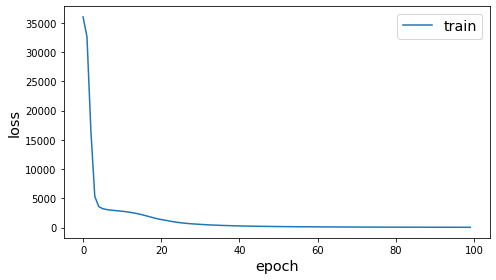

In [31]:
plot_history(history)

In [35]:
embeddings = wys.embeddings()

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

nodelist = list(stellarG.nodes())

labels = node_subjects.loc[nodelist]
target_encoding = OneHotEncoder(sparse=False)
label_vectors = target_encoding.fit_transform(labels.values.reshape(-1, 1))

KeyError: "None of [Index(['0x906e55e1035c8a0828f249c173d8090e8fd5f189',\n       '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7',\n       '0x0a4eafeb533d4111a1fe3a8b323c468976ac2323',\n       '0xa4eafeb533d4111a1fe3a8b323c468976ac2323',\n       '0xd7c902fbbcd3c9db2da80a439c94486c50eb81',\n       '0xb9fddbd225b6c8cc24ce193e5fb95db76d783f2d',\n       '0xe369a8d4e8799d381cd5734eafd812cfb5c2574a',\n       '0xd93033ac253ce4320128666d999c392cfc09a523',\n       '0x80ac8b6f4cacea6129f5cf1365904f056b4e29ea',\n       '0xb4bb4156e5e6ca5d81041f616c27dffb253b7845',\n       ...\n       '0x78e6fe8e1d14a914c53b08e302e35443909dd24f',\n       '0x285be47bee9f9e4d9a16d9707c868eed10667020',\n       '0xaedaf3d364f56476e7bec717c63f645eb5b2ecdd',\n       '0xd79b9316ab0aed9b5f99f870b9f74c11d8d40cd5',\n       '0xf98a39456903cfde206603bdd1e1d4227dbe1243',\n       '0x8bfe24fb29f57a6fe885884963549d905dc035f2',\n       '0x9179de43eafb051053f4ab99b9d9292d20eea723',\n       '0x3945476e477de76d53b4833a46c806ef3d72b21e',\n       '0xe08c32737c021c7d05d116b00a68a02f2d144ac0', 'nan'],\n      dtype='object', length=5124)] are in the [index]"

In [34]:
embeddings

array([[-0.29142904,  0.28193483,  0.16778737, ...,  1.5218345 ,
        -2.6806567 ,  3.2458978 ],
       [-0.11893788,  0.13561043, -0.03561752, ...,  1.8129877 ,
        -0.37022597,  0.8383368 ],
       [-0.45439398, -0.18121709, -0.552358  , ...,  2.4978495 ,
        -2.5589764 ,  0.76931643],
       ...,
       [ 0.13534616,  0.17777234, -0.5382055 , ...,  0.7306167 ,
        -1.5943211 ,  1.0489849 ],
       [-0.16204666, -0.08214192, -0.35513413, ...,  1.0681038 ,
        -1.4637922 ,  0.07720358],
       [-0.25422144,  0.2784831 ,  0.36910143, ...,  4.5838146 ,
        -4.6947474 ,  3.0884402 ]], dtype=float32)

In [ ]:
transform = TSNE

trans = transform(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=nodelist)

emb_transformed["label"] = np.argmax(label_vectors, 1)

alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)

ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of Watch Your Step embeddings for cora dataset".format(
        transform.__name__
    )
)
plt.show()

In [ ]:
# TODO: NLP clustering: https://stellargraph.readthedocs.io/en/stable/demos/embeddings/metapath2vec-embeddings.html

In [15]:
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import os
import networkx as nx
import numpy as np
import pandas as pd
from tensorflow import keras

from stellargraph import StellarGraph
from stellargraph.data import BiasedRandomWalk
from stellargraph.data import UnsupervisedSampler
from stellargraph.data import BiasedRandomWalk
from stellargraph.mapper import Node2VecLinkGenerator, Node2VecNodeGenerator
from stellargraph.layer import Node2Vec, link_classification

from stellargraph import datasets
from IPython.display import display, HTML

%matplotlib inline

In [16]:
walk_number = 100
walk_length = 5

In [17]:
walker = BiasedRandomWalk(
    stellarG,
    n=walk_number,
    length=walk_length,
    p=0.5,  # defines probability, 1/p, of returning to source node
    q=2.0,  # defines probability, 1/q, for moving to a node away from the source node
)



In [18]:
unsupervised_samples = UnsupervisedSampler(stellarG, nodes=list(G.nodes()), walker=walker)

In [19]:
batch_size = 50
epochs = 2
generator = Node2VecLinkGenerator(stellarG, batch_size)

In [20]:
emb_size = 128
node2vec = Node2Vec(emb_size, generator=generator)

In [21]:
x_inp, x_out = node2vec.in_out_tensors()

In [22]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="dot"
)(x_out)

model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

history = model.fit(
    generator.flow(unsupervised_samples),
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)



link_classification: using 'dot' method to combine node embeddings into edge embeddings
Epoch 1/2
78576/78576 [==============================] - 401s 5ms/step - loss: 0.5485 - binary_accuracy: 0.6774


KeyboardInterrupt: 

In [ ]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [ ]:
node_gen = Node2VecNodeGenerator(G, batch_size).flow(subjects.index)
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)



In [ ]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()

In [19]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

In [20]:
nodes = list(stellarG.nodes())
number_of_walks = 1
length = 5

In [21]:
unsupervised_samples = UnsupervisedSampler(
    stellarG, nodes=nodes, length=length, number_of_walks=number_of_walks
)

In [22]:
batch_size = 50
epochs = 4
num_samples = [10, 5]
generator = GraphSAGELinkGenerator(stellarG, batch_size, num_samples)
train_gen = generator.flow(unsupervised_samples)

In [23]:
layer_sizes = [50, 50]
graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)



In [24]:
x_inp, x_out = graphsage.in_out_tensors()

In [25]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [26]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=4,
    shuffle=True,
)

Epoch 1/4
434/434 [==============================] - 34s 76ms/step - loss: 0.5881 - binary_accuracy: 0.7093
Epoch 2/4
434/434 [==============================] - 32s 73ms/step - loss: 0.5403 - binary_accuracy: 0.7765
Epoch 3/4
434/434 [==============================] - 32s 73ms/step - loss: 0.5341 - binary_accuracy: 0.7856
Epoch 4/4
434/434 [==============================] - 31s 71ms/step - loss: 0.5355 - binary_accuracy: 0.7885


In [27]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline



In [28]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [33]:
node_ids = node_subjects.index
node_gen = GraphSAGENodeGenerator(stellarG, batch_size, num_samples).flow(node_ids)

In [34]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

55/55 [==============================] - 2s 40ms/step


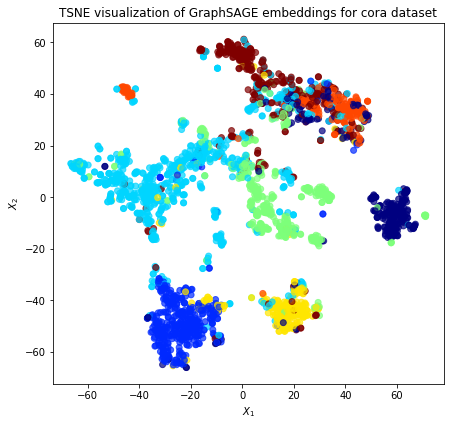

In [35]:
node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
    emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = node_subject
    
    
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

In [24]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random

import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification

from tensorflow import keras

from pandas.core.indexes.base import Index

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

from stellargraph import datasets
from IPython.display import display, HTML

In [21]:
nodes = list(G.nodes())
number_of_walks = 4
length = 5


unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, length=length, number_of_walks=number_of_walks
)



In [22]:
batch_size = 50
epochs = 4

In [25]:
generator = Attri2VecLinkGenerator(G, batch_size)
train_gen = generator.flow(unsupervised_samples)

In [26]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


In [27]:
layer_sizes = [128]
attri2vec = Attri2Vec(
    layer_sizes=layer_sizes, generator=generator, bias=False, normalize=None
)

In [28]:
# Build the model and expose input and output sockets of attri2vec, for node pair inputs:
x_inp, x_out = attri2vec.in_out_tensors()



In [29]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)


link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [30]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [31]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/4
1734/1734 - 4s - loss: 0.6970 - binary_accuracy: 0.5379
Epoch 2/4
1734/1734 - 4s - loss: 0.6358 - binary_accuracy: 0.6292
Epoch 3/4
1734/1734 - 4s - loss: 0.4934 - binary_accuracy: 0.7790
Epoch 4/4
1734/1734 - 4s - loss: 0.3905 - binary_accuracy: 0.8404


In [32]:
x_inp_src = x_inp[0]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)


In [36]:
node_gen = Attri2VecNodeGenerator(G, batch_size).flow(subjects.index)
node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=1)



50/50 [==============================] - 0s 749us/step


In [37]:
transform = TSNE  # PCA

trans = transform(n_components=2)
node_embeddings_2d = trans.fit_transform(node_embeddings)

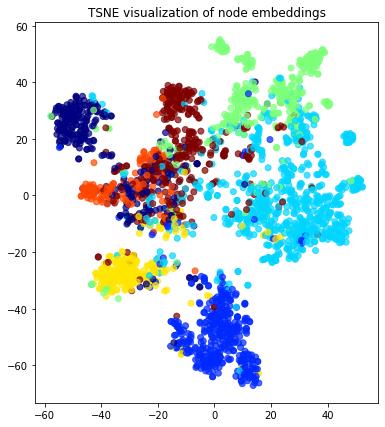

In [38]:
# draw the embedding points, coloring them by the target label (paper subject)
alpha = 0.7
label_map = {l: i for i, l in enumerate(np.unique(subjects))}
node_colours = [label_map[target] for target in subjects]

plt.figure(figsize=(7, 7))
plt.axes().set(aspect="equal")
plt.scatter(
    node_embeddings_2d[:, 0],
    node_embeddings_2d[:, 1],
    c=node_colours,
    cmap="jet",
    alpha=alpha,
)
plt.title("{} visualization of node embeddings".format(transform.__name__))
plt.show()



In [14]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [15]:
def run_deep_graph_infomax(
    base_model, generator, epochs, reorder=lambda sequence, subjects: subjects
):
    corrupted_generator = CorruptedGenerator(generator)
    gen = corrupted_generator.flow(G.nodes())
    infomax = DeepGraphInfomax(base_model, corrupted_generator)

    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])

    x_emb_in, x_emb_out = base_model.in_out_tensors()
    # for full batch models, squeeze out the batch dim (which is 1)
    if generator.num_batch_dims() == 2:
        x_emb_out = tf.squeeze(x_emb_out, axis=0)

    emb_model = Model(inputs=x_emb_in, outputs=x_emb_out)

    test_gen = generator.flow(test_subjects.index)
    train_gen = generator.flow(train_subjects.index)

    test_embeddings = emb_model.predict(test_gen)
    train_embeddings = emb_model.predict(train_gen)

    # some generators yield predictions in a different order to the .flow argument,
    # so we need to get everything lined up correctly
    ordered_test_subjects = reorder(test_gen, test_subjects)
    ordered_train_subjects = reorder(train_gen, train_subjects)

    lr = LogisticRegression(multi_class="auto", solver="lbfgs")
    lr.fit(train_embeddings, ordered_train_subjects)

    y_pred = lr.predict(test_embeddings)
    acc = (y_pred == ordered_test_subjects).mean()

    return acc

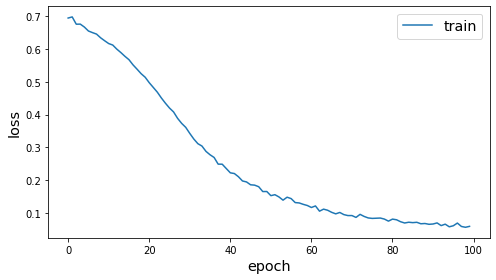

In [16]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))

epochs=100
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [17]:
cluster_generator = ClusterNodeGenerator(stellarG, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")


Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233


NameError: name 'test_subjects' is not defined

In [49]:
gat_model = GAT(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator, attn_heads=8,
)
gat_acc = run_deep_graph_infomax(gat_model, fullbatch_generator, epochs=epochs)

gat_acc
print(f"Test classification accuracy: {gat_acc}")

KeyError: array(['0x906e55e1035c8a0828f249c173d8090e8fd5f189',
       '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7',
       '0x0a4eafeb533d4111a1fe3a8b323c468976ac2323', ...,
       '0x3945476e477de76d53b4833a46c806ef3d72b21e',
       '0xe08c32737c021c7d05d116b00a68a02f2d144ac0', 'nan'], dtype='<U42')

In [50]:
appnp_model = APPNP(
    layer_sizes=[128], activations=["relu"], generator=fullbatch_generator
)
appnp_acc = run_deep_graph_infomax(appnp_model, fullbatch_generator, epochs=epochs)

print(f"Test classification accuracy: {appnp_acc}")

KeyError: array(['0x906e55e1035c8a0828f249c173d8090e8fd5f189',
       '0x0e9aed5c7721c642a032812c2c4816f7d6cb87d7',
       '0x0a4eafeb533d4111a1fe3a8b323c468976ac2323', ...,
       '0x3945476e477de76d53b4833a46c806ef3d72b21e',
       '0xe08c32737c021c7d05d116b00a68a02f2d144ac0', 'nan'], dtype='<U42')

In [51]:
graphsage_generator = GraphSAGENodeGenerator(stellarG, batch_size=1000, num_samples=[5])

graphsage_model = GraphSAGE(
    layer_sizes=[128], activations=["relu"], generator=graphsage_generator
)
graphsage_acc = run_deep_graph_infomax(
    graphsage_model, graphsage_generator, epochs=epochs
)

print(f"Test classification accuracy: {graphsage_acc}")

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning

In [15]:
dataset = datasets.Cora()

In [16]:
display(HTML(dataset.description))

In [35]:
G, subjects = dataset.load(largest_connected_component_only=True)

In [32]:
cluster_generator = ClusterNodeGenerator(G, clusters=12, q=4)
cluster_gcn_model = GCN(
    layer_sizes=[128], activations=["relu"], generator=cluster_generator
)


def cluster_reorder(sequence, subjects):
    # shuffle the subjects into the same order as the sequence yield
    return subjects[sequence.node_order]


cluster_gcn_acc = run_deep_graph_infomax(
    cluster_gcn_model, cluster_generator, epochs=epochs, reorder=cluster_reorder
)
print(f"Test classification accuracy: {cluster_gcn_acc}")


Number of clusters 12
0 cluster has size 225
1 cluster has size 225
2 cluster has size 225
3 cluster has size 225
4 cluster has size 225
5 cluster has size 225
6 cluster has size 225
7 cluster has size 225
8 cluster has size 225
9 cluster has size 225
10 cluster has size 225
11 cluster has size 233
Test classification accuracy: 0.6579163248564397


In [18]:
fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)
gcn_model = GCN(layer_sizes=[128], activations=["relu"], generator=fullbatch_generator)

corrupted_generator = CorruptedGenerator(fullbatch_generator)
gen = corrupted_generator.flow(G.nodes())

Using GCN (local pooling) filters...


In [19]:
infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
x_in, x_out = infomax.in_out_tensors()

model = Model(inputs=x_in, outputs=x_out)
model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(lr=1e-3))


In [21]:
epochs = 100

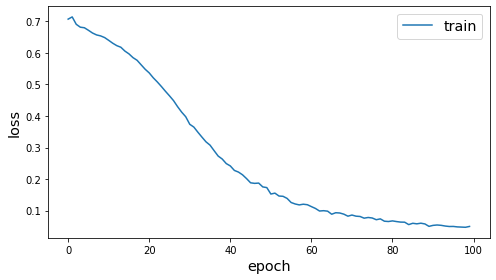

In [22]:
es = EarlyStopping(monitor="loss", min_delta=0, patience=20)
history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es])
plot_history(history)

In [24]:
G.node_features()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
G.nodes()

Int64Index([  31336, 1061127, 1106406,   13195,   37879, 1126012, 1107140,
            1102850,   31349, 1106418,
            ...
             626531, 1131180, 1130454, 1131184, 1128974, 1128975, 1128977,
            1128978,  117328,   24043],
           dtype='int64', length=2708)

In [27]:
x_emb_in, x_emb_out = gcn_model.in_out_tensors()

# for full batch models, squeeze out the batch dim (which is 1)
x_out = tf.squeeze(x_emb_out, axis=0)
emb_model = Model(inputs=x_emb_in, outputs=x_out)

In [28]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.1, test_size=None, stratify=node_subjects
)

test_gen = fullbatch_generator.flow(test_subjects.index)
train_gen = fullbatch_generator.flow(train_subjects.index)

test_embeddings = emb_model.predict(test_gen)
train_embeddings = emb_model.predict(train_gen)

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_subjects)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_subjects).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.8022969647251845


In [29]:
all_embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes()))

y = node_subjects.astype("category")
trans = TSNE(n_components=2)
emb_transformed = pd.DataFrame(trans.fit_transform(all_embeddings), index=G.nodes())
emb_transformed["label"] = y

KeyboardInterrupt: 

In [ ]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].cat.codes,
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE visualization of GCN embeddings for cora dataset")
plt.show()

In [147]:
wallet_of_interest = output.loc[output['cluster'] == random_cluster, :].index.tolist()
edge_df.loc[(edge_df['WinnerAddress'].isin(wallet_of_interest))|(edge_df['SellerAddress'].isin(wallet_of_interest))]

SellerAddress  \
17994   0x9b35dbc596f545739e25e203b41823251acdee17   
32431   0x9b35dbc596f545739e25e203b41823251acdee17   
71084   0x9b35dbc596f545739e25e203b41823251acdee17   
79819   0x9b35dbc596f545739e25e203b41823251acdee17   
82404   0x9b35dbc596f545739e25e203b41823251acdee17   
95675   0x9b35dbc596f545739e25e203b41823251acdee17   
111041  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
147717  0xeee5eb24e7a0ea53b75a1b9ad72e7d20562f4283   
148909  0x9b35dbc596f545739e25e203b41823251acdee17   
155873  0x9b35dbc596f545739e25e203b41823251acdee17   
155878  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
156142  0xb1a8757c8d71f5ef878d56a1fb045c592a7ef6e4   
156144  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
160272  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36   
166139  0x9b35dbc596f545739e25e203b41823251acdee17   

                                     WinnerAddress            Timestamp  \
17994   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T11:31:41   
32431   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T12:03:46   
71084   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T11:01:49   
79819   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-26T12:03:49   
82404   0x53ede7cae3eb6a7d11429fe589c0278c9acbe21a  2020-08-28T11:57:51   
95675   0x1d1ef89654fe251fef926a721c5a393dfc50b489  2020-11-17T12:21:50   
111041                                         NaN  2019-09-17T05:52:00   
147717  0x9b35dbc596f545739e25e203b41823251acdee17  2020-12-21T19:18:53   
148909  0xd387a6e4e84a6c86bd90c158c6028a58cc8ac459  2020-08-30T10:43:23   
155873  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36  2020-10-24T01:34:24   
155878                                         NaN  2019-09-17T05:46:33   
156142  0xa1b2c179955310fa41e561661d2c3f1ca90b1e36  2021-02-17T22:07:45   
156144                                         NaN  2019-09-17T06:03:10   
160272                                         NaN  2019-09-17T05:55:28   
166139   0xa4eafeb533d4111a1fe3a8b323c468976ac2323  2020-09-13T22:06:44   

         EventType PaymenTokenSymbol            TotalPrice  TokenId  \
17994   successful               ETH   1100000000000000000     9182   
32431   successful               ETH   1100000000000000000     8308   
71084   successful               ETH   1100000000000000000     6259   
79819   successful               ETH   1400000000000000000     5769   
82404   successful               ETH   1100000000000000000     5620   
95675   successful               ETH  11000000000000000000     4851   
111041  successful               ETH    450000000000000000     3906   
147717  successful               ETH   3700000000000000000     1904   
148909  successful               ETH   1200000000000000000     1841   
155873  successful               ETH   5300000000000000000     1416   
155878  successful               ETH    400000000000000000     1416   
156142  successful               ETH  10000000000000000000     1397   
156144  successful               ETH    300000000000000000     1397   
160272  successful               ETH    450000000000000000     1045   
166139  successful               ETH   5500000000000000000      544   

                              AssetContractAddress  AssetId  TransactionId  \
17994   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530625     42460607.0   
32431   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   530103     42464569.0   
71084   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528837     42456169.0   
79819   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528519     42464619.0   
82404   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   528430     42848564.0   
95675   0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   178734     60574542.0   
111041  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   179336      9757908.0   
147717  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   179619     68433082.0   
148909  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   176547     43258165.0   
155873  0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb   1

In [106]:
output.head()

0  cluster
0x000000000cc7e508b4b115e64d71ef374cfb7703   {'c_infomap': 65}       65
0x000000aaee6a496aaf7b7452518781786313400f  {'c_infomap': 547}      547
0x0006e4548aed4502ec8c844567840ce6ef1013f5  {'c_infomap': 317}      317
0x00084121aec4309cb20db622a28c717720e888e0  {'c_infomap': 389}      389
0x000e8c608473dcee93021eb1d39fb4a7d7e7d780  {'c_infomap': 431}      431

In [78]:

Gs = sg.StellarGraph.from_networkx(G)
print(Gs.info())



StellarGraph: Undirected multigraph
 Nodes: 4912, Edges: 12226

 Node types:
  default: [4912]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [12226]
        Weights: all 1 (default)
        Features: none


In [79]:
# parameter specification
number_of_walks = 3
length = 5
batch_size = 50
epochs = 10
num_samples = [20, 20]
layer_sizes = [100, 100]
learning_rate = 1e-2

In [80]:
unsupervisedSamples = UnsupervisedSampler(
    Gs, nodes=G.nodes(), length=length, number_of_walks=number_of_walks
)

In [81]:
generator = GraphSAGELinkGenerator(Gs, batch_size, num_samples)
train_gen = generator.flow(unsupervisedSamples)

RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning

##### Node Embedding part
- Adjacency matrix
- DGI

In [38]:
def get_adj_mat_dense(G):
    adj_mat = adjacency_matrix(G)
    return adj_mat.todense()

##### Typical ML Clustering part
- K-Means
- Hierarchical clustering
- DBSCAN
- Gaussian Mixture

In [39]:
def kmeans_clustering(X, n_cluster):
    model = KMeans(n_clusters=n_cluster)
    output = model.fit_predict(X)
    inertia = model.inertia_
    distortion = sum(np.min(cdist(X, model.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    return output, inertia, distortion

def kmeans_experiment(X, n_clusters):
    dist_eval = []
    for n_cluster in n_clusters:
        print(n_cluster)
        _, inertia, distortion = kmeans_clustering(X, n_cluster)
        dist_eval.append([n_cluster, inertia, distortion])
    return dist_eval

In [43]:
def hierarchical_clustering(X, n_cluster, dist_thr):
    if n_cluster != None:
        model = AgglomerativeClustering(n_clusters=n_cluster, compute_full_tree=True)
    else:
        model = AgglomerativeClustering(n_clusters=n_cluster, distance_threshold=dist_thr)
        
    output = model.fit_predict(X)
    avg_distance = sum(model.distances_) / model.n_clusters_
#     distortion = sum(np.min(cdist(X, model.cluster_centers_,
#                                    'euclidean'), axis=1)) / X.shape[0]
    return output, avg_distance#, distortion

def hierarchical_experiment(X, n_clusters, dist_thr):
    dist_eval = []
    for n_cluster in n_clusters:
        _, avg_distance = hierarchical_clustering(X, n_cluster, None)
        dist_eval.append([n_cluster, None, avg_distance])
        
    for threshold in dist_thr:
        _, avg_distance = hierarchical_clustering(X, None, threshold)
        dist_eval.append([None, threshold, avg_distance])
        
    return dist_eval

In [55]:
from sklearn import metrics
def DBSCAN_clustering(X, eps, min_samples):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    silhouette_score = metrics.silhouette_score(X, labels)
    return n_clusters, n_noise, silhouette_score

def DBSCAN_experiment(X, eps_range, min_samples_range):
    perf_comp = []
    for eps in eps_range:
        for min_samples in min_samples_range:
            n_cluster, n_noise, silhouette_score = DBSCAN_clustering(X, eps, min_samples)
            perf_comp.append([eps, min_samples, n_cluster, n_noise, silhouette_score])
    return perf_comp

##### Set up embeddings and models

In [41]:
embeddings = {}

for embedding_type, clustering_model_type in model_options:
    if embedding_type not in embeddings.keys():
        embeddings[embedding_type] = get_adj_mat_dense(G)

# RUN AI EXPERIMENTS

In [113]:
perf_comp = kmeans_experiment(embeddings['AdjMatrix'], n_clusters)
perf_comp

4
5
6
7
8


[[4, 23344.777603513234, 1.7636841074649565],
 [5, 23081.102347377906, 1.758514433283089],
 [6, 23076.39699316563, 1.7544630504684238],
 [7, 22973.751472913016, 1.743579023595804],
 [8, 22641.376382753624, 1.7388112419690283]]

In [116]:
kmeans_experiment(embeddings['AdjMatrix'], [250])

250


[[250, 12614.83483962637, 1.341489133210721]]

In [44]:
perf_comp = hierarchical_experiment(embeddings['AdjMatrix'], [], dist_thr)
perf_comp

/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/usr/local/lib/python3.6/dist-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance ma

[[None, 3, 9.311040466539351],
 [None, 5, 24.793601981339194],
 [None, 7, 57.71843902107458],
 [None, 9, 124.83290299906827]]

In [56]:
perf_comp = DBSCAN_experiment(embeddings['AdjMatrix'], eps, min_samples)
perf_comp

[[0.3, 3, 174, 3868, -0.0786114563614406],
 [0.3, 5, 71, 4216, -0.1473086895981082],
 [0.2, 3, 174, 3868, -0.0786114563614406],
 [0.2, 5, 71, 4216, -0.1473086895981082]]

In [68]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2
node_count = len(node_features)

split_index = np.zeros((node_count), dtype=np.int)
split_index[:round(node_count * train_ratio)] = 1
split_index[round(node_count*train_ratio): round(node_count*(train_ratio+val_ratio))] = 2
split_index[round(node_count*(train_ratio+val_ratio)):] = 3

np.random.shuffle(split_index)

print("Node count in train:\t", sum(split_index == 1))
print("Node count in val:\t", sum(split_index == 2))
print("Node count in test:\t", sum(split_index == 3))
print("Total Sum Check:", sum(split_index == 1) + sum(split_index == 2) + sum(split_index == 3) == node_count)

Node count in train:	 139779
Node count in val:	 46593
Node count in test:	 46593
Total Sum Check: True


In [70]:
g.ndata['train_mask'] = torch.tensor(split_index == 1)
g.ndata['val_mask'] = torch.tensor(split_index == 2)
g.ndata['test_mask'] = torch.tensor(split_index == 3)

In [84]:
print(g.ndata)

{'feat': tensor([[ 1.2334,  9.0430, -0.9233,  ..., -0.2579,  0.3112, -0.3772],
        [-0.1386, -0.2022,  0.1277,  ...,  0.1563,  0.1048, -0.6534],
        [-0.1330, -0.1962, -0.0296,  ...,  0.0358,  0.2864,  0.2744],
        ...,
        [-0.0614, -0.2022,  0.9698,  ...,  1.1064, -1.4323, -0.2398],
        [-0.1606, -0.2022, -0.0892,  ...,  0.7440, -0.5046, -2.2288],
        [ 0.0929,  0.2822,  0.1768,  ...,  0.2196,  0.5967,  0.5588]],
       dtype=torch.float64), 'train_mask': tensor([ True,  True,  True,  ..., False,  True, False]), 'val_mask': tensor([False, False, False,  ...,  True, False,  True]), 'test_mask': tensor([False, False, False,  ..., False, False, False]), 'label': tensor([30, 17, 18,  ...,  3, 13, 13])}


# AI Experiment

In [111]:
# Algorithm 1: GCN
from dgl.nn import GraphConv
class GCN(nn.Module):
    def __init__(self, feat_dim, h_feat_dim, num_classes):
        super(GCN, self).__init__()
        
        self.num_layer = len(h_feat_dim)
        self.h_feat_dim = h_feat_dim
        self.num_classes = num_classes
        
        self.layers = []
        prev_dim = feat_dim
        for i in range(self.num_layer):
            print(prev_dim)
            print(h_feat_dim[i])
            self.layers.append(GraphConv(prev_dim, h_feat_dim[i]))
            prev_dim = h_feat_dim[i]
        self.layers.append(GraphConv(prev_dim, num_classes))
        
    def forward(self, g, in_feat):
        prev_feat = in_feat
        for i in len(self.num_layer-1):
            h = self.layers[i](g, prev_feat)
            h = F.relu(h)
            prev_feat = h
        h = self.layers[-1](g)

In [92]:
feat_dim = len(node_features[0])
num_classes = len(np.unique(node_labels))

# THIS IS THE INPUTS FOR EXPERIMENTATION
#Experimentation Scope

model_types = ['GCN', 'GraphSAGE']
aggregators = ['mean', 'max']
h_feat_dim = [[32], [16], [8], [32, 16], [32, 8], [16, 4], [32, 16, 4]]
activation_func = ['relu', 'sigmoid']
loss_func = ['cross_entropy']
optimization = ['adam', 'sgd']
opt_learning_rate = [0.01, 0.1]
train_iter = 100

In [95]:
# Create an experimentation table
tracking_values = []
exp_ID_counter = 0
for m in model_types:
    for ag in aggregators:
        for h in h_feat_dim:
            for a in activation_func:
                for l in loss_func:
                    for opt in optimization:
                        for opt_lr in opt_learning_rate:
                            for i in range(train_iter):
                                tracking_values.append([exp_ID_counter, i, m, ag, len(h), h, a, l, opt, opt_lr])
                            exp_ID_counter += 1
                            
tracking_df = pd.DataFrame(tracking_values)
tracking_df.columns = ['expID', 'iter', 'model', 'aggregator', 'num_layer', 'layer_dim', 
                        'activation_func', 'loss_func', 'optimization', 'opt_lr']

performance_cols = ['loss', 'acc_train', 'avg_recall_train', 'avg_prec_train', 'avg_f1_train', 
                    'acc_val', 'avg_recall_val', 'avg_prec_val', 'avg_f1_val']

for c in performance_cols:
    tracking_df[c] = None

In [113]:
tracking_df.head()

expID  iter model aggregator  num_layer layer_dim activation_func  \
0      0     0   GCN       mean          1      [32]            relu   
1      0     1   GCN       mean          1      [32]            relu   
2      0     2   GCN       mean          1      [32]            relu   
3      0     3   GCN       mean          1      [32]            relu   
4      0     4   GCN       mean          1      [32]            relu   

       loss_func optimization  opt_lr  loss acc_train avg_recall_train  \
0  cross_entropy         adam    0.01  None      None             None   
1  cross_entropy         adam    0.01  None      None             None   
2  cross_entropy         adam    0.01  None      None             None   
3  cross_entropy         adam    0.01  None      None             None   
4  cross_entropy         adam    0.01  None      None             None   

  avg_prec_train avg_f1_train acc_val avg_recall_val avg_prec_val avg_f1_val  
0           None         None    None           None         None       None  
1           None         None    None           None         None       None  
2           None         None    None           None         None       None  
3           None         None    None           None         None       None  
4           None         None    None           None         None       None

In [123]:
def get_optimizer(model, optimizer_type, learning_rate):
    print(model.parameters())
    if optimizer_type == "adam":
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    elif optimizer_type == "sgd":
        optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
    else:
        print(optimizer_type, "is currently not supported!")
        return None
    return optimizer

def run_node_clf_exp(g, train_iter, h_feat_dim, optimizer_type, opt_lr, loss_func):
    model = GCN(g.ndata['feat'].shape[1], h_feat_dim, len(g.ndata['label'].unique()))
    optimizer = get_optimizer(model, optimizer_type, opt_lr)
    
    best_train_acc = 0
    best_val_acc = 0
    best_test_acc = 0
    
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    
    for e in range(train_iter):
        logits = model(g, features)   # forward
        pred = logits.argmax(1)       # compute prediction
        
        # TODO check the loss function type. Currently only cross entropy is supported
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[train_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[train_mask] == labels[test_mask]).float().mean()
        
        # Save the best validation accuracy
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc
            
        # Backward prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if e%5 == 0:
            print("In epoch {}, loss: {:.3f}, val acc: {:.3f}, test acc: {.3f} (best{:.3f})".format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_all))

In [125]:
model = GCN(g.ndata['feat'].shape[1], [32], len(g.ndata['label'].unique()))

602
32


In [126]:
model.parameters()

<generator object Module.parameters at 0x7fcc3d748258>

In [127]:
torch.optim.Adam(model.parameters(), lr=0.01)

ValueError: optimizer got an empty parameter list

In [124]:
for ind, row in tracking_df.iterrows():
    m = row['model']
    ag = row['aggregator']
    h = row['layer_dim']
    a = row['activation_func']
    l = row['loss_func']
    opt = row['optimization']
    lr = row['opt_lr']
    
    print(m, ag, h, a, l, opt, lr)
    
    run_node_clf_exp(g, 10, h, opt, lr, l)
    break

GCN mean [32] relu cross_entropy adam 0.01
602
32
<generator object Module.parameters at 0x7fcc3d7481a8>


ValueError: optimizer got an empty parameter list

In [ ]:
# train
optimizer = torch.optim.Adam(model.parameters)